In [90]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import inv

### Class Definition

In [109]:
class KalmanFilter(object):
    def __init__(self,F,Q,H,R,u):
        """
        Initialize the dynamical system models.
        Parameters
        ----------
        F : ndarray of shape (n,n)
            The state transition model.
        Q : ndarray of shape (n,n)
            The covariance matrix for the state noise.
        H : ndarray of shape (m,n)
            The observation model.
        R : ndarray of shape (m,m)
            The covariance matric for observation noise.
        u : ndarray of shape (n,)
            The control vector.
        """
        self.F = F
        self.F_inv = inv(F)
        self.Q = Q
        self.H = H
        self.R = R
        self.u = u
        
    def evolve(self,x0,N):
        """
        Compute the first N states and observations generated by the Kalman system.
        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state.
        N : integer
            The number of time steps to evolve.
        Returns
        -------
        states : ndarray of shape (n,N)
            States 0 through N-1, given by each column.
        obs : ndarray of shape (2,N)
            Observations 0 through N-1, given by each column.
        """
        n = x0.shape[0]
        states = np.zeros((n,N))
        obs = np.zeros((2,N))
        Z2 = np.array([0,0])
        Z4 = np.array([0,0,0,0])
        states[:,0] = x0
        obs[:,0] = self.H.dot(states[:,0]) + np.random.multivariate_normal(Z2,self.R)
        for i in range(1,N) :
            states[:,i] = self.F.dot(states[:,i-1]) + self.u + np.random.multivariate_normal(Z4,self.Q)
            obs[:,i] = self.H.dot(states[:,i-1]) + np.random.multivariate_normal(Z2,self.R)
        return states,obs
    
    def estimate(self,x,P,z):
        """
        Compute the state estimates using the Kalman filter.
        If x and P correspond to time step k, then z is a sequence of
        observations starting at time step k+1.
        Parameters
        ----------
        x : ndarray of shape (n,)
            The initial state estimate.
        P : ndarray of shape (n,n)
            The initial error covariance matrix.
        z : ndarray of shape(m,N)
            Sequence of N observations (each column is an observation).
        Returns
        -------
        out : ndarray of shape (n,N)
            Sequence of state estimates (each column is an estimate).
        """
        n = x.shape[0]
        N = z.shape[1]
        out = np.zeros((n,N))
        # Predict 1
        out[:,0] = self.F.dot(x) + self.u
        P = np.dot(self.F.dot(P),self.F.T) + self.Q
        # Update 1
        yk = z[:,0] - self.H.dot(out[:,0])
        Sk = np.dot(self.H.dot(P),self.H.T) + self.R
        Kk = np.dot(P.dot(self.H.T),inv(Sk))
        x = out[:,0] + Kk.dot(yk)
        P = (np.eye(4)-Kk.dot(self.H)).dot(P)
        # Iterate through predict and update
        for i in range(1,N) :
            # Predict
            out[:,i] = self.F.dot(x) + self.u
            P = np.dot(self.F.dot(P),self.F.T) + self.Q
            # Update
            yk = z[:,i] - self.H.dot(out[:,i])
            Sk = np.dot(self.H.dot(P),self.H.T) + self.R
            Kk = np.dot(P.dot(self.H.T),inv(Sk))
            x = out[:,i] + Kk.dot(yk)
            P = (np.eye(4)-Kk.dot(self.H)).dot(P)
        return out
    
    def predict(self,x,k):
        """
        Predict the next k states in the absence of observations.
        Parameters
        ----------
        x : ndarray of shape (n,)
            The current state estimate.
        k : integer
            The number of states to predict.
        Returns
        -------
        out : ndarray of shape (n,k)
            The next k predicted states.
        """
        n = x.shape[0]
        out = np.zeros((n,k+1))
        out[:,0] = x
        for i in range(1,k+1) :
            out[:,i] = self.F.dot(out[:,i-1]) + self.u
        return out
    
    def rewind(self,x,k):
        """
        Predict the k states preceding the current state estimate x.
        Parameters
        ----------
        x : ndarray of shape (n,)
            The current state estimate.
        k : integer
            The number of preceding states to predict.
        Returns
        -------
        out : ndarray of shape (n,k)
            The k preceding predicted states.
        """
        n = x.shape[0]
        out = np.zeros((n,k+1))
        out[:,0] = x
        for i in range(1,k+1) :
            out[:,i] = self.F_inv.dot(out[:,i-1] - self.u)
        return out[:,:-1]

### Problem 2

In [110]:
t_step = 0.1
F = np.array([[1,0,0.1,0],[0,1,0,0.1],[0,0,1,0],[0,0,0,1]])
u = np.array([0,0,0,-.98])
H = np.array([[1,0,0,0],[0,1,0,0]])
Q = 0.1*np.eye(4)
R = 5000*np.eye(2)
kf = KalmanFilter(F,Q,H,R,u)

### Problem 3

In [111]:
x0 = np.array([0,0,300,600])
N = 1250
states,obs = kf.evolve(x0,N)

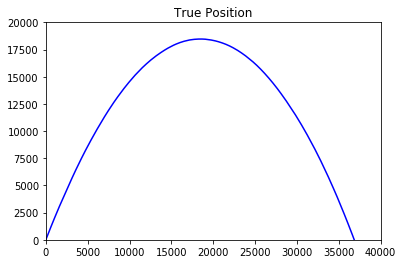

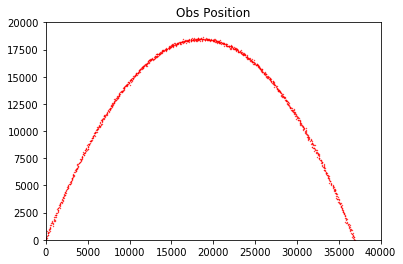

In [112]:
plt.plot(states[0,:],states[1,:],'b')
plt.title('True Position')
plt.axis([0,40000,0,20000])
plt.show()
plt.scatter(obs[0,:],obs[1,:],c='r',marker='.',s=.5)
plt.title('Obs Position')
plt.axis([0,40000,0,20000])
plt.show()

### Problem 5

In [113]:
N = 600
x = np.array([0,0,0,0])
x[:2] = obs[:,200]
z = obs[:,200:801]
diff_matr = np.diff(z[:,:9],axis=1)
avg = np.sum(diff_matr,axis=1)/8
x[2:] = avg
P = 10**6*Q
x = x.astype(float)
out = kf.estimate(x,P,z)

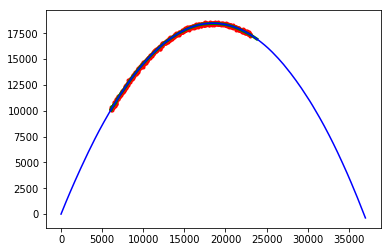

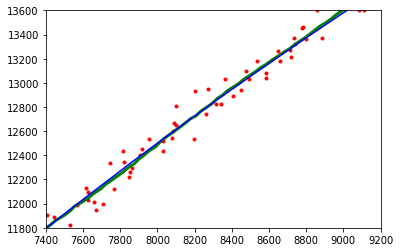

In [114]:
plt.plot(out[0,:],out[1,:],'g',linewidth=3.0)
plt.plot(states[0,:],states[1,:],'b')
plt.scatter(obs[0,200:775],obs[1,200:775],c='r',marker='.')
plt.show()
plt.plot(out[0,:],out[1,:],'g',linewidth=3.0)
plt.plot(states[0,:],states[1,:],'b')
plt.scatter(obs[0,200:775],obs[1,200:775],c='r',marker='.')
plt.axis([7400,9200,11800,13600])
plt.show()

### Problem 7

In [115]:
x_800 = out[:,-1]
pred = kf.predict(x_800,450)

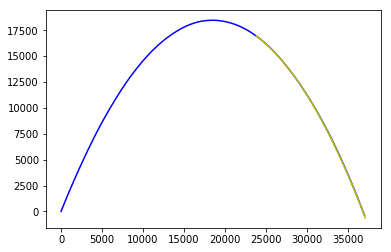

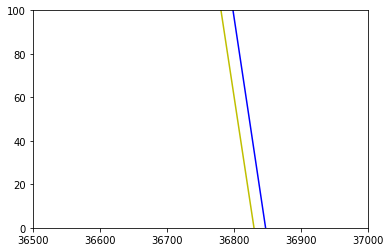

In [118]:
plt.plot(states[0,:],states[1,:],'b')
plt.plot(pred[0,:],pred[1,:],'y')
plt.show()
plt.plot(states[0,:],states[1,:],'b')
plt.plot(pred[0,:],pred[1,:],'y')
plt.axis([36500,37000,0,100])
plt.show()

### Problem 9

In [127]:
x_250 = out[:,50]
rew = kf.rewind(x_250,300)

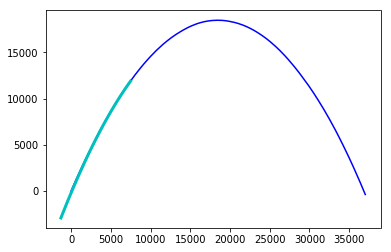

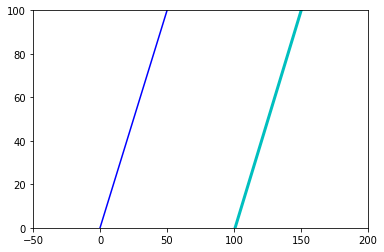

In [130]:
plt.plot(states[0,:],states[1,:],'b')
plt.plot(rew[0,:],rew[1,:],'c',linewidth=3.0)
plt.show()
plt.plot(states[0,:],states[1,:],'b')
plt.plot(rew[0,:],rew[1,:],'c',linewidth=3.0)
plt.axis([-50,200,0,100])
plt.show()